# Notebook for Part 4

This notebook contains the script and analysis for part 4 of the assessment 3.

In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
import statsmodels.api as sm
from math import sin, cos, sqrt, atan2, radians
from sklearn.preprocessing import normalize
from linearmodels.panel import RandomEffects

In [2]:
# Import weather data and happiness data
proc_weather_path = '..\proc_data\weather'
proc_happiness_path = '..\proc_data\happiness'
weather_df = pd.read_csv(os.path.join(proc_weather_path,'weather.csv'))
happiness_df = pd.read_excel(os.path.join(proc_happiness_path, 'happiness.xlsx'))

## Look for any temporal effects that we neglected earlier: Are people happier in years when the weather is better?

To answer this question, I look at happiness data and the weather data from 2011 to 2014. Define better weather as less rain, more sun hours, less af days, warmer tmax, warmer tmin; using the mean as the threshold, I would "score" each of these variables as 1 if it falls on the "better" side and 0 otherwise. The score will range from 0 to 5 with higher score indicating better weather. I would use data Visualisation to inspect the patterns in the data then based on summary statistics, gather conclusion.

In [3]:
# Group by year and area names
happiness_year_df = happiness_df.groupby(['year','Area names'])['0-4','5-6','7-8','9-10','Average rating','lat','lon'].mean().reset_index()
happiness_year_df.head()

,year,Area names,0-4,5-6,7-8,9-10,Average rating,lat,lon
0,2011,EAST,9.66,17.02,40.96,32.36,7.37,52.2,0.4
1,2011,EAST MIDLANDS,10.93,17.66,38.35,33.07,7.32,53.0,-0.8
2,2011,LONDON,11.17,19.48,40.16,29.20,7.19,51.5,-0.1
3,2011,NORTH EAST,12.16,18.78,38.59,30.47,7.18,55.0,-1.9
4,2011,NORTHERN IRELAND,9.80,16.20,41.10,33.00,7.40,54.6,-5.9


In [4]:
weather_year_df = weather_df.groupby(['station','yyyy'])['tmax degC','tmin degC','af days','rain mm','sun hours','lat','lon'].mean().reset_index()
weather_year_df.head()

,station,yyyy,tmax degC,tmin degC,af days,rain mm,sun hours,lat,lon
0,aberporth,1941,NaN,NaN,NaN,65.575000,NaN,52.139,-4.57
1,aberporth,1942,12.283333,6.716667,NaN,80.166667,131.091667,52.139,-4.57
2,aberporth,1943,12.750000,7.233333,NaN,82.708333,134.758333,52.139,-4.57
3,aberporth,1944,12.425000,7.425000,NaN,72.466667,122.975000,52.139,-4.57
4,aberporth,1945,13.000000,7.658333,NaN,71.808333,121.241667,52.139,-4.57


In [5]:
def compute_distance(lat1, lon1, lat2, lon2):
    '''
    Function to compute distance between to points given their lat long.
    Adapted from source: "https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude"
    lat1 (float): latitude of point 1
    lon1 (float): longitude of point 1
    lat2 (float): latitude of point 2
    lon2 (float): longitude of point 2
    '''
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [6]:
def assign_nearest_region(weather_df_agg, happiness_df_avg):
    '''
    Assign the nearest region to the station based on the lat long
    weather_df_agg (dataframe): aggregated weather data
    happiness_df_ave (dataframe): average happiness data
    '''
    
    for i in range(len(weather_df_agg)):
        # For each station find the the nearest region and assign region to it

        dist_lst = []

        for j in range(len(happiness_df_avg)):
            dist_lst.append(compute_distance(happiness_df_avg.loc[j,'lat'], happiness_df_avg.loc[j,'lon'], weather_df_agg.loc[i, 'lat'], weather_df_agg.loc[i, 'lon']))

            # Find the shortest distances
            weather_df_agg.loc[i,'Region'] = happiness_df_avg.loc[np.argmin(dist_lst),'Area names']

            # Keep region lat lon for manual sanity checks
            weather_df_agg.loc[i,'Region lat'] = happiness_df_avg.loc[np.argmin(dist_lst),'lat']
            weather_df_agg.loc[i,'Region lon'] = happiness_df_avg.loc[np.argmin(dist_lst),'lon']
    
    return weather_df_agg

In [7]:
happiness_regions_df = happiness_year_df[['Area names','lat','lon']].drop_duplicates()
happiness_regions_df

,Area names,lat,lon
0,EAST,52.2,0.4
1,EAST MIDLANDS,53.0,-0.8
2,LONDON,51.5,-0.1
3,NORTH EAST,55.0,-1.9
4,NORTHERN IRELAND,54.6,-5.9
5,SCOTLAND,56.0,-3.2
6,SOUTH EAST,51.3,-0.5
7,SOUTH WEST,51.0,-3.2
8,WALES,51.5,-3.2
9,WEST MIDLANDS,52.5,-2.3


In [8]:
weather_dedup = weather_df[['station','lat','lon']].drop_duplicates().reset_index(drop = True)
weather_dedup.head()

,station,lat,lon
0,aberporth,52.139,-4.570
1,armagh,54.352,-6.649
2,ballypatrick,55.181,-6.153
3,bradford,53.813,-1.772
4,braemar,57.006,-3.396


In [9]:
# Map the stations to the nearest region
station_mapping_table = assign_nearest_region(weather_dedup,happiness_regions_df)

# Merge to weather year df
weather_year_df = pd.merge(weather_year_df, station_mapping_table.drop(columns = ['lat','lon']), how = 'inner', on = 'station')
weather_year_df

,station,yyyy,tmax degC,tmin degC,af days,rain mm,sun hours,lat,lon,Region,Region lat,Region lon
0,aberporth,1941,NaN,NaN,NaN,65.575000,NaN,52.139,-4.570,WALES,51.5,-3.2
1,aberporth,1942,12.283333,6.716667,NaN,80.166667,131.091667,52.139,-4.570,WALES,51.5,-3.2
2,aberporth,1943,12.750000,7.233333,NaN,82.708333,134.758333,52.139,-4.570,WALES,51.5,-3.2
3,aberporth,1944,12.425000,7.425000,NaN,72.466667,122.975000,52.139,-4.570,WALES,51.5,-3.2
4,aberporth,1945,13.000000,7.658333,NaN,71.808333,121.241667,52.139,-4.570,WALES,51.5,-3.2
...,...,...,...,...,...,...,...,...,...,...,...,...
3203,yeovilton,2017,15.300000,6.983333,3.666667,53.950000,117.583333,51.006,-2.641,SOUTH WEST,51.0,-3.2
3204,yeovilton,2018,15.783333,6.958333,3.333333,56.750000,133.300000,51.006,-2.641,SOUTH WEST,51.0,-3.2
3205,yeovilton,2019,15.458333,6.666667,3.500000,63.416667,124.441667,51.006,-2.641,SOUTH WEST,51.0,-3.2
3206,yeovilton,2020,15.850000,7.191667,2.750000,66.358333,140.000000,51.006,-2.641,SOUTH WEST,51.0,-3.2


In [10]:
weather_happiness_year_df = pd.merge(weather_year_df, happiness_year_df.drop(columns = ['lat','lon']), how = 'inner', left_on = ['Region','yyyy'], right_on = ['Area names','year'])
weather_happiness_year_df

,station,yyyy,tmax degC,tmin degC,af days,rain mm,sun hours,lat,lon,Region,Region lat,Region lon,year,Area names,0-4,5-6,7-8,9-10,Average rating
0,aberporth,2011,13.266667,8.033333,1.250000,61.383333,136.691667,52.139,-4.570,WALES,51.5,-3.2,2011,WALES,11.56,17.42,37.92,33.10,7.29
1,cardiff,2011,15.308333,7.883333,2.000000,77.458333,NaN,51.488,-3.187,WALES,51.5,-3.2,2011,WALES,11.56,17.42,37.92,33.10,7.29
2,rossonwye,2011,15.383333,7.441667,2.083333,43.483333,127.866667,51.911,-2.584,WALES,51.5,-3.2,2011,WALES,11.56,17.42,37.92,33.10,7.29
3,aberporth,2012,12.358333,7.466667,1.333333,96.066667,116.283333,52.139,-4.570,WALES,51.5,-3.2,2012,WALES,11.01,17.72,39.59,31.68,7.29
4,cardiff,2012,14.408333,6.916667,3.166667,124.700000,NaN,51.488,-3.187,WALES,51.5,-3.2,2012,WALES,11.01,17.72,39.59,31.68,7.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,waddington,2012,13.291667,6.166667,2.916667,68.900000,112.258333,53.175,-0.522,EAST MIDLANDS,53.0,-0.8,2012,EAST MIDLANDS,10.07,17.81,39.78,32.34,7.35
130,suttonbonington,2013,13.666667,5.900000,4.833333,46.200000,NaN,52.833,-1.250,EAST MIDLANDS,53.0,-0.8,2013,EAST MIDLANDS,9.29,18.03,39.15,33.53,7.41
131,waddington,2013,13.216667,6.050000,5.000000,43.133333,124.875000,53.175,-0.522,EAST MIDLANDS,53.0,-0.8,2013,EAST MIDLANDS,9.29,18.03,39.15,33.53,7.41
132,suttonbonington,2014,15.150000,7.075000,2.083333,52.541667,NaN,52.833,-1.250,EAST MIDLANDS,53.0,-0.8,2014,EAST MIDLANDS,8.66,16.74,38.62,35.99,7.51


In [11]:
# Get the variables of interest
vars_lst = ['year','tmax degC', 'tmin degC', 'af days', 'rain mm', 'sun hours','Average rating']
weather_happiness_year_df_cleaned = weather_happiness_year_df[vars_lst].dropna()

In [12]:
weather_happiness_year_df_cleaned

,year,tmax degC,tmin degC,af days,rain mm,sun hours,Average rating
0,2011,13.266667,8.033333,1.250000,61.383333,136.691667,7.29
2,2011,15.383333,7.441667,2.083333,43.483333,127.866667,7.29
3,2012,12.358333,7.466667,1.333333,96.066667,116.283333,7.29
5,2012,14.175000,6.383333,3.500000,87.725000,120.050000,7.29
6,2013,12.416667,7.208333,2.666667,72.791667,130.908333,7.39
...,...,...,...,...,...,...,...
125,2014,14.175000,8.708333,0.166667,78.583333,137.633333,7.43
127,2011,14.725000,7.066667,2.000000,35.291667,123.133333,7.32
129,2012,13.291667,6.166667,2.916667,68.900000,112.258333,7.35
131,2013,13.216667,6.050000,5.000000,43.133333,124.875000,7.41


Data Visualisation and summary statistics

In [13]:
def assign_weather_score(weather_df_raw):
    '''
    Assigns weather score based on whether it falls on the "better" side of the mean weather variable
    Returns a modified weather dataframe witht the scores assigned
    weather_df_raw (pandas dataframe object): weather dataframe
    '''
    
    # Define better weathers: less rain, less af days, warmer tmax, warmer tmin, more sun hours
    # Get the mean weather
    mean_weather = weather_df_raw[['tmax degC', 'tmin degC', 'af days', 'rain mm', 'sun hours']].mean()
    
    weather_df = weather_df_raw.copy()

    # Assign according to the various weather variable's assumption
    weather_df['tmax score'] = weather_df['tmax degC'].apply(lambda x: 1 if x > mean_weather['tmax degC'] else 0)
    weather_df['tmin score'] = weather_df['tmin degC'].apply(lambda x: 1 if x > mean_weather['tmin degC'] else 0)
    weather_df['af days score'] = weather_df['af days'].apply(lambda x: 1 if x <= mean_weather['af days'] else 0)
    weather_df['rain score'] = weather_df['rain mm'].apply(lambda x: 1 if x <= mean_weather['rain mm'] else 0)
    weather_df['sun hours score'] = weather_df['sun hours'].apply(lambda x: 1 if x > mean_weather['sun hours'] else 0)
    
    # Overall weather score
    weather_df['Overall Weather Score'] = weather_df['tmax score'] + weather_df['tmin score'] + weather_df['af days score'] + weather_df['rain score'] + weather_df['sun hours score']
    
    return weather_df

In [14]:
weather_happiness_year_df_cleaned = assign_weather_score(weather_happiness_year_df_cleaned)

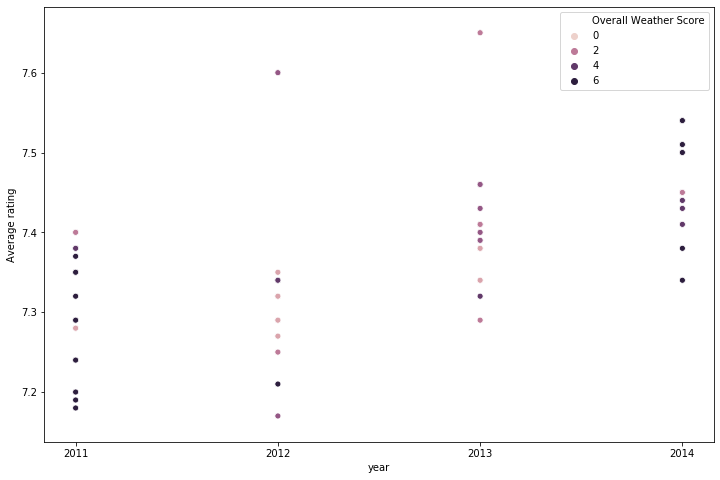

In [15]:
# Visualise the data
plt.figure(figsize=(12,8))
g = sns.scatterplot(data = weather_happiness_year_df_cleaned, x = 'year', y = 'Average rating', hue = 'Overall Weather Score')
g = g.set(xticks=weather_happiness_year_df_cleaned['year'].unique())
plt.show()

In [16]:
summary_table = weather_happiness_year_df_cleaned.groupby('year')[['Overall Weather Score', 'Average rating']].agg(['mean','std'])
summary_table

Overall Weather Score           Average rating          
                      mean       std           mean       std
year                                                         
2011              3.400000  1.914854       7.295600  0.070064
2012              1.875000  1.569062       7.327083  0.095666
2013              2.166667  1.372610       7.412500  0.083835
2014              3.454545  1.503243       7.460000  0.052554

From this summary table, it does appear that in years when weather is better, the average rating are not really affected by it. For instance, 2011 and 2014 which saw better weather conditions in general saw a mixed result in average happiness rating. Happiness rating in 2011 was the lowest among all years, and 2014 was higher among all 4 years.

I re-did a similar analysis as above but this time aggregating by region names first before year aggregation but it yields the same inconclusive results as follows:

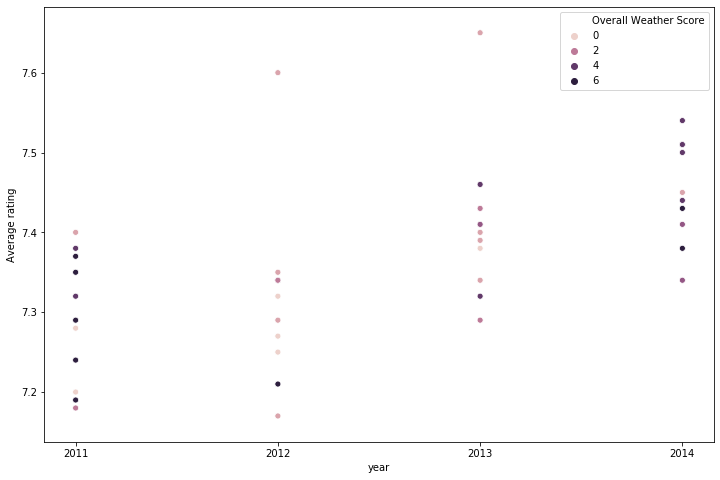

Overall Weather Score           Average rating          
                      mean       std           mean       std
year                                                         
2011              3.272727  2.101947       7.290909  0.079932
2012              1.636364  1.689540       7.316364  0.111020
2013              1.818182  1.328020       7.407273  0.094455
2014              3.800000  1.229273       7.451000  0.064023

In [17]:
# Aggregate by year and region
weather_happiness_year_df_region_agg = weather_happiness_year_df.groupby(['year','Region'])['tmax degC', 'tmin degC', 'af days', 'rain mm', 'sun hours','Average rating'].mean().reset_index()

# Assign weather score
weather_happiness_year_df_region_agg = assign_weather_score(weather_happiness_year_df_region_agg)

# Visualise the data
plt.figure(figsize=(12,8))
g = sns.scatterplot(data = weather_happiness_year_df_region_agg, x = 'year', y = 'Average rating', hue = 'Overall Weather Score')
g = g.set(xticks=weather_happiness_year_df_cleaned['year'].unique())
plt.show()

summary_table_region_agg = weather_happiness_year_df_region_agg.groupby('year')[['Overall Weather Score', 'Average rating']].agg(['mean','std'])
summary_table_region_agg

## Investigation of whether better weather results in higher happiness index after accounting for the temporal effects and the regional effects.

In this section, I investigated whether better weather results in higher happiness after accounting for temporal effects and regional-specific effects.

In [18]:
df = sm.add_constant(weather_happiness_year_df_region_agg[['Overall Weather Score','year','Region','Average rating']])

year = pd.Categorical(df['year'])

# Set multi-index
df = df.sort_values(['Region','year'])
df = df.set_index(['Region','year'])
df['year'] = year
endog = df['Average rating']
exog = df.drop(columns ='Average rating')
re_mod = RandomEffects(endog, exog)
re_res = re_mod.fit()
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:         Average rating   R-squared:                        0.6986
Estimator:              RandomEffects   R-squared (Between):             -0.1742
No. Observations:                  43   R-squared (Within):               0.1114
Date:                Sun, Apr 25 2021   R-squared (Overall):             -0.0377
Time:                        19:14:29   Log-likelihood                    46.807
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      22.016
Entities:                          11   P-value                           0.0000
Avg Obs:                       3.9091   Distribution:                    F(4,38)
Min Obs:                       3.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             0.5938
                            

C:\Users\angsi\anaconda3\envs\py36\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
